# Neural Network Library - Project Milestone 1 Demo

CSE473s: Computational Intelligence - Fall 2025

## Overview

This notebook demonstrates a complete neural network library built from scratch using only NumPy.

**Part 1: Core Library Validation**
1. **Gradient Checking**: Verification of backpropagation correctness
2. **XOR Problem**: Solving the classic XOR classification task

In [1]:
%load_ext autoreload
%autoreload 2
# Import required libraries
import numpy as np
import sys

# Add library to path
sys.path.insert(0, '../')

# Import our neural network library
from lib import Network, Dense, ReLU, Sigmoid, Tanh, Softmax, MSE, SGD, plot_losses, plot_decision_boundary

In [2]:
# XOR dataset
X = np.array([
    [-1,-1],
    [-1,1],
    [1,-1],
    [1,1]
], dtype=float)

y = np.array([
    [-1],
    [1],
    [1],
    [-1]
], dtype=float)

Epoch 0, Loss: 1.000356
Epoch 500, Loss: 0.001393
Epoch 1000, Loss: 0.000477
Epoch 1500, Loss: 0.000284
Epoch 2000, Loss: 0.000201
Epoch 2500, Loss: 0.000155
Epoch 3000, Loss: 0.000126
Epoch 3500, Loss: 0.000106
Epoch 4000, Loss: 0.000092
Epoch 4500, Loss: 0.000081

Network Architecture:
Layer 0: Dense | Weights: (2, 4) | Biases: (1, 4)
Layer 1: Tanh
Layer 2: Dense | Weights: (4, 1) | Biases: (1, 1)
Layer 3: Tanh


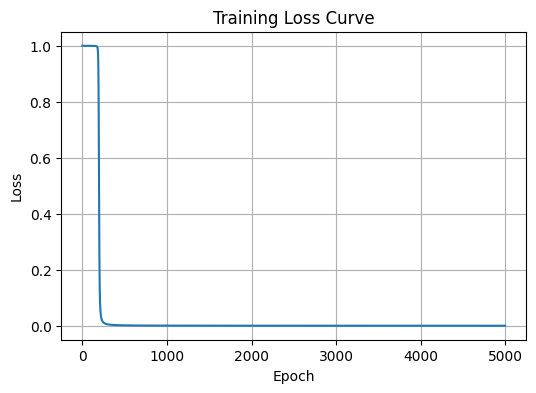


VISUALIZATION: Binary Decision Boundary


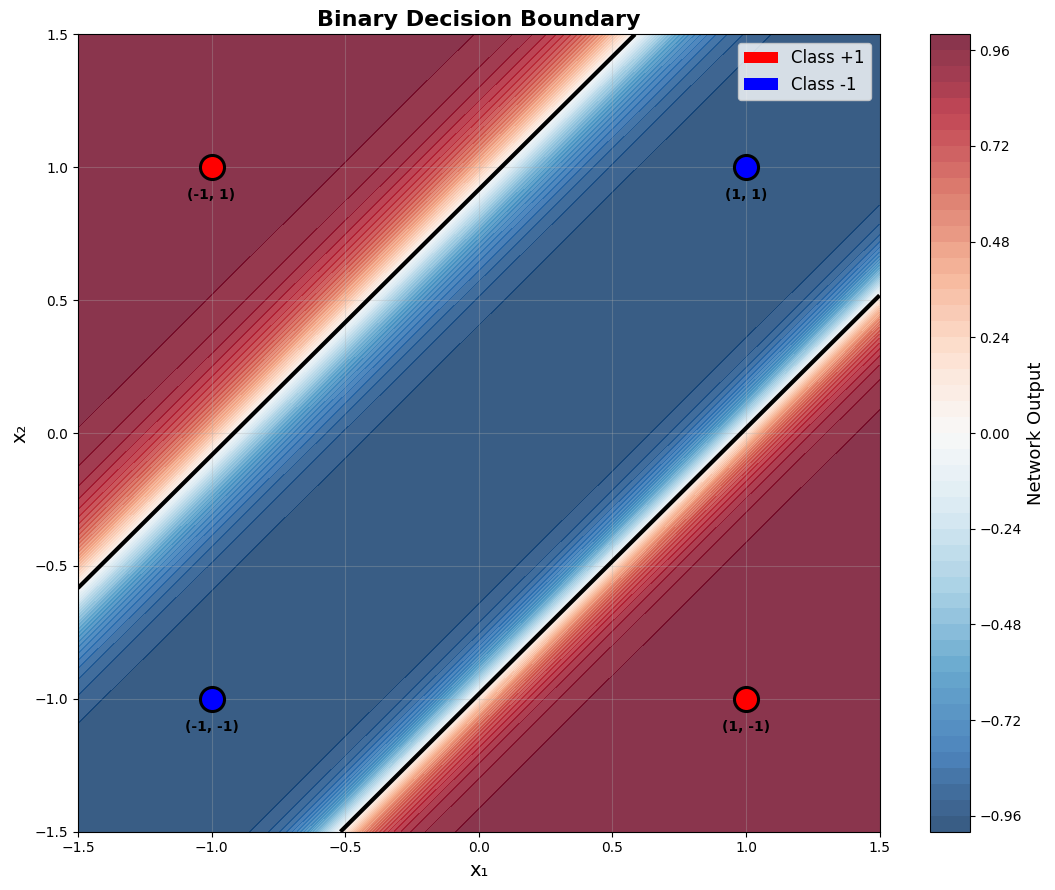

Binary decision boundary visualization complete!


In [3]:
model = Network([
    Dense(2, 4),
    Tanh(),
    Dense(4, 1),
    Tanh()
])

loss_fn = MSE()
optimizer = SGD(learning_rate=0.5)

model.train(X, y, loss_fn, optimizer, epochs=5000, verbose=True)

model.summary()

plot_losses(model.loss_history)
plot_decision_boundary(model, X, y)

In [4]:
def gradient_check(model, X, y, loss_fn, epsilon=1e-5, tol=1e-7):
    """
    Performs gradient checking for all Dense layers in the model.
    
    Arguments:
        model    : Network object
        X, y     : Input and target output
        loss_fn  : Loss class (e.g., MSE)
        epsilon  : Small value for numerical gradient
        tol      : Tolerance for max difference
    """
    
    # 1. Forward and backward pass to compute analytical gradients
    y_pred = model.forward(X)
    grad_output = loss_fn.grad(y_pred, y)
    model.backward(grad_output)
    
    for idx, layer in enumerate(model.layers):
        if hasattr(layer, 'W'):
            print(f"\n--- Layer {idx} ---")
            
            # ----- Gradient for weights -----
            num_grad_W = np.zeros_like(layer.W)
            for i in range(layer.W.shape[0]):
                for j in range(layer.W.shape[1]):
                    old_val = layer.W[i,j]
                    
                    layer.W[i,j] = old_val + epsilon
                    loss_plus = loss_fn.loss(model.forward(X), y)
                    
                    layer.W[i,j] = old_val - epsilon
                    loss_minus = loss_fn.loss(model.forward(X), y)
                    
                    num_grad_W[i,j] = (loss_plus - loss_minus) / (2*epsilon)
                    layer.W[i,j] = old_val  # reset
            
            max_diff_W = np.max(np.abs(num_grad_W - layer.dW))
            print(f"Max difference in W: {max_diff_W}")
            
            # ----- Gradient for biases -----
            num_grad_b = np.zeros_like(layer.b)
            for i in range(layer.b.shape[1]):
                old_val = layer.b[0,i]
                
                layer.b[0,i] = old_val + epsilon
                loss_plus = loss_fn.loss(model.forward(X), y)
                
                layer.b[0,i] = old_val - epsilon
                loss_minus = loss_fn.loss(model.forward(X), y)
                
                num_grad_b[0,i] = (loss_plus - loss_minus) / (2*epsilon)
                layer.b[0,i] = old_val  # reset
            
            max_diff_b = np.max(np.abs(num_grad_b - layer.db))
            print(f"Max difference in b: {max_diff_b}")
            
            if max_diff_W < tol and max_diff_b < tol:
                print("Gradients match within tolerance.")
            else:
                print("Warning: Gradients may be incorrect.")

gradient_check(model, X, y, loss_fn)



--- Layer 0 ---
Max difference in W: 5.3983635731101945e-14
Max difference in b: 1.4489376088918163e-14
Gradients match within tolerance.

--- Layer 2 ---
Max difference in W: 1.5163888753607496e-14
Max difference in b: 1.8660827006897196e-14
Gradients match within tolerance.


f:\University\Senior_2\CI\Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

TensorFlow model predictions:
Input: [-1. -1.], Predicted: -0.9913, True: -1.0
Input: [-1.  1.], Predicted: 0.9915, True: 1.0
Input: [ 1. -1.], Predicted: 0.9965, True: 1.0
Input: [1. 1.], Predicted: -0.9925, True: -1.0

Custom model predictions:
Input: [-1. -1.], Predicted: -0.9933, True: -1.0
Input: [-1.  1.], Predicted: 0.9904, True: 1.0
Input: [ 1. -1.], Predicted: 0.9898, True: 1.0
Input: [1. 1.], Predicted: -0.9933, True: -1.0

Max difference between custom model and TensorFlow model predictions: 0.006742481127216204

VISUALIZATION: Binary Decision Boundary
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 737us/step


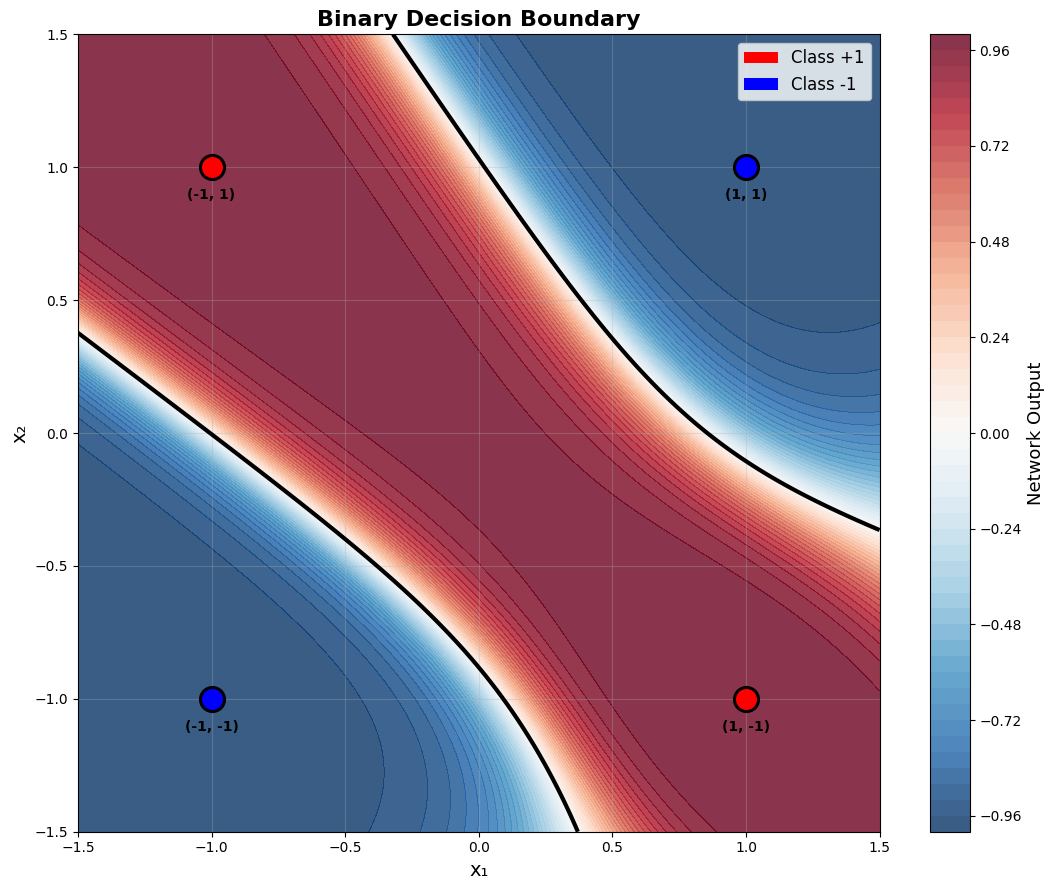

Binary decision boundary visualization complete!


In [5]:
import tensorflow as tf
from tensorflow import keras
# Simple TensorFlow model for XOR
tf_model = keras.Sequential([
    keras.layers.Dense(4, activation='tanh', input_shape=(2,)),
    keras.layers.Dense(1, activation='tanh')
])
tf_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.5), loss='mean_squared_error')
tf_model.fit(X, y, epochs=5000, verbose=0)

y_tf_pred = tf_model.predict(X)

print("\nTensorFlow model predictions:")
for i in range(len(X)):
    print(f"Input: {X[i]}, Predicted: {y_tf_pred[i][0]:.4f}, True: {y[i][0]}")

# Predictions
y_pred = model.predict(X)
print("\nCustom model predictions:")
for i in range(len(X)):
    print(f"Input: {X[i]}, Predicted: {y_pred[i][0]:.4f}, True: {y[i][0]}")

# Compare predictions
diff = np.abs(y_pred - y_tf_pred)
max_diff = np.max(diff)
print(f"\nMax difference between custom model and TensorFlow model predictions: {max_diff}")

# Decision boundary for TensorFlow model
def tf_predict(X):
    return tf_model.predict(X)
plot_decision_boundary(tf_predict, X, y)

